In [2]:
import os
# insert the GTK3 Runtime folder at the beginning. Can be bin or lib, depending on path you choose while installing.
GTK_FOLDER = r'C:\Program Files\GTK3-Runtime Win64\bin'
os.environ['PATH'] = GTK_FOLDER + os.pathsep + os.environ.get('PATH', '')

In [ ]:
import os
import random
import shutil
import math

In [ ]:
1+1

In [4]:
from doctr.models import ocr_predictor
from doctr.io import DocumentFile
from datetime import datetime
import json
from PIL import Image
import os

# Ensure the 'annotations' directory exists
if not os.path.exists('../data/annotations'):
    os.makedirs('../data/annotations')


data_dir =  '../data'

# Path to the directory containing the cropped images and labels.json
annotations_dir = '../data/annotations'
labels_file = os.path.join(annotations_dir, 'labels.json')

# Initialize a dictionary to hold the JSON structure for labels
labels = {}

# Load model(s)
model = ocr_predictor(det_arch='db_resnet50', reco_arch='parseq', pretrained=True)

folder_path = '../data/orig_images'
image_paths = os.listdir(folder_path)
image_paths = ['../data/orig_images/'+i for i in image_paths]

for image_path in image_paths: 
    name_of_label = image_path.split("/")[-1].split("_")[0]
    img = Image.open(image_path)
    # Check if the image is in landscape (width > height)
    if img.width > img.height:
        # Rotate the image by 270 degrees clockwise
        img = img.transpose(Image.Transpose.ROTATE_270)
    doc = DocumentFile.from_images(image_path)
    # Analyze
    result = model(doc)
    data = result.export()
    data = data["pages"][0]

    # Loop through each block, line, and word to extract the words and create labels
    for block in data['blocks']:
        for line in block['lines']:
            for word in line['words']:
                # Get the word coordinates
                coords = word['geometry']
                # Calculate the coordinates on the image
                left = img.width * coords[0][0]
                top = img.height * coords[0][1]
                right = img.width * coords[1][0]
                bottom = img.height * coords[1][1]
                
                # Crop the image to the word
                word_img = img.crop((left, top, right, bottom))
                
                # Generating a timestamp with the current hour, minute, second, milliseconds as a string
                # Get the current time
                current_time_precise = datetime.now()
                
                # Format the time to include hour, minute, second, milliseconds, and day
                timestamp_precise = current_time_precise.strftime("%H%M%S%f")
                
                # Define the filename with suffix
                filename = f"img_{name_of_label}_{timestamp_precise}.png"
                
                # Save the cropped image with the new filename
                word_img.save(f"{annotations_dir}/{filename}")
                
                # Add the entry to the labels dictionary
                labels[filename] = name_of_label
                
# Save the updated labels dictionary back to the JSON file
with open(labels_file, 'w') as f:
    json.dump(labels, f)

In [16]:
# Load the labels from the labels.json file
with open(labels_file, 'r') as f:
    labels = json.load(f)

# Get a list of all filenames in the 'annotations' directory
existing_files = os.listdir(annotations_dir)

# Remove keys from the dictionary for files that don't exist
labels = {filename: word for filename, word in labels.items() if filename in existing_files}

# Save the updated labels dictionary back to the JSON file
with open(labels_file, 'w') as f:
    json.dump(labels, f)
# The labels dictionary is now updated with only existing files.


In [19]:
data_dir =  '../data'

# Create train and validation folders if they don't exist
train_folder = os.path.join(data_dir, 'train_path')
val_folder = os.path.join(data_dir, 'val_path')

train_folder_images = os.path.join(train_folder, 'images')
val_folder_images = os.path.join(val_folder, 'images')

os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(train_folder_images, exist_ok=True)
os.makedirs(val_folder_images, exist_ok=True)

# List all the image files in the folder
image_files = os.listdir(annotations_dir)
image_files = [i for i in image_files if i!="labels.json"]

# Create dictionaries to keep track of counts for each category
train_counts = {}
val_counts = {}

# Define the desired train-validation split ratio
split_ratio = 0.8

# Iterate through the image files
for image_file in image_files:
    # Extract the name portion of the filename (e.g., "img_peter")
    name = image_file.split('_')[0]

    # Determine if the image should go to the train or validation set
    if name not in train_counts:
        train_counts[name] = 0
        val_counts[name] = 0

    if train_counts[name] / (train_counts[name] + val_counts[name] + 1) < split_ratio:
        train_counts[name] += 1
        destination_folder = train_folder_images
    else:
        val_counts[name] += 1
        destination_folder = val_folder_images

    # Create a copy of the image file in the appropriate folder
    source_path = os.path.join(annotations_dir, image_file)
    destination_path = os.path.join(destination_folder, image_file)
    shutil.copy2(source_path, destination_path)

In [20]:
for i in [(train_folder, train_folder_images), (val_folder, val_folder_images)]:
    # Load the labels from the labels.json file
    with open(labels_file, 'r') as f:
        labels = json.load(f)
    
    # Get a list of all filenames in the 'annotations' directory
    existing_files = os.listdir(i[1])
    
    # Remove keys from the dictionary for files that don't exist
    labels = {filename: word for filename, word in labels.items() if filename in existing_files}
    
    labels_file_new = os.path.join(i[0], 'labels.json')
    
    # Save the updated labels dictionary back to the JSON file
    with open(labels_file_new, 'w') as f:
        json.dump(labels, f)
    # The labels dictionary is now updated with only existing files.


In [137]:
import torch
from doctr.models import ocr_predictor, db_resnet50, crnn_vgg16_bn, parseq

reco_model = parseq(pretrained=False, pretrained_backbone=False)
reco_params = torch.load('/home/lucas/Documents/doctra/doctr/parseq_20240102-003756.pt', map_location="cpu")
reco_model.load_state_dict(reco_params)
model = ocr_predictor(det_arch='db_resnet50', reco_arch=reco_model, pretrained=True)

In [116]:
image_paths = ['8fbef6a6-7a1e-466a-abab-63d2adc9af98.JPG', 'trans.png', 'manip.png', 'WhatsApp Image 2024-01-01 at 22.24.08.jpeg']

In [117]:
image_paths[0]

'trans.png'

In [131]:
# Load model(s)
model = ocr_predictor(det_arch='db_resnet50', reco_arch='parseq', pretrained=True)


In [142]:
img = Image.open('WhatsApp Image 2024-01-01 at 22.24.08.jpeg')
doc = DocumentFile.from_images('WhatsApp Image 2024-01-01 at 22.24.08.jpeg')


In [143]:
# Analyze
result = model(doc)
data = result.export()
data = data["pages"][0]

In [144]:
data

{'page_idx': 0,
 'dimensions': (1024, 768),
 'orientation': {'value': None, 'confidence': None},
 'language': {'value': None, 'confidence': None},
 'blocks': [{'geometry': ((0.125, 0.115234375),
    (0.27864583333333337, 0.3564453125)),
   'lines': [{'geometry': ((0.15234375, 0.115234375),
      (0.27864583333333337, 0.1591796875)),
     'words': [{'value': 'Lucas',
       'confidence': 0.9998782277107239,
       'geometry': ((0.15234375, 0.115234375),
        (0.27864583333333337, 0.1591796875))}]},
    {'geometry': ((0.14973958333333331, 0.173828125),
      (0.25911458333333337, 0.20703125)),
     'words': [{'value': 'Lucas',
       'confidence': 0.9999226331710815,
       'geometry': ((0.14973958333333331, 0.173828125),
        (0.25911458333333337, 0.20703125))}]},
    {'geometry': ((0.14713541666666669, 0.216796875),
      (0.24348958333333331, 0.24609375)),
     'words': [{'value': 'Lucas',
       'confidence': 0.9998178482055664,
       'geometry': ((0.14713541666666669, 0.21679

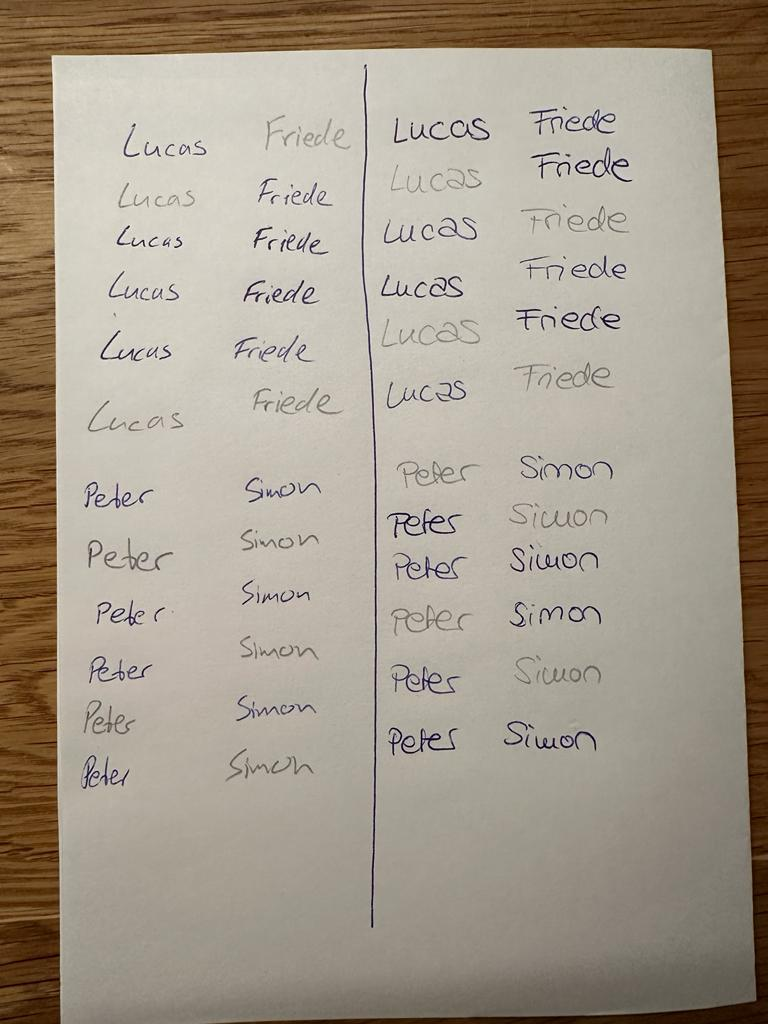

In [146]:
img

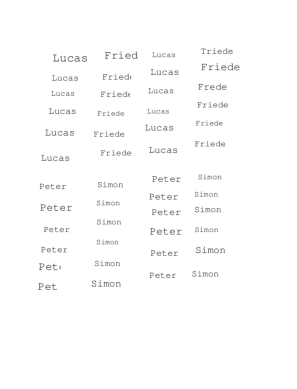

In [145]:
import matplotlib.pyplot as plt

synthetic_pages = result.synthesize()
plt.imshow(synthetic_pages[0]); plt.axis('off'); plt.show()

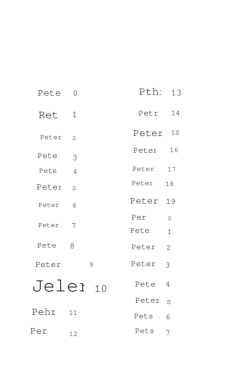

In [130]:
import matplotlib.pyplot as plt

synthetic_pages = result.synthesize()
plt.imshow(synthetic_pages[0]); plt.axis('off'); plt.show()